# Przewidywanie dostępności stacjonarnego internetu szerokopasmowego na podstawie lokalizacji

autor: Tomasz Taraś

## Spis treści
* Wstęp
* Zbiory danych wykorzystane w pracy
    * Dane o infrastrukturze szerokopasmowej i zasięgach (SIIS)
    * Dane o adresach z Państwowego Rejestru Granic (PRG)
    * Modele 3D budynków (LOD1)
    * Numeryczny Model Terenu (NMT)
    * Dane o nazwach urzędowych jednostek administracyjnych, miejscowości i ulic (rejestr TERYT)
* Przygotowanie danych o infrastrukturze szerokopasmowej
    * Zasięgi
    * Węzły i interfejsy
* Przygotowanie danych adresowych wraz z potrzebnymi dla modelu informacjami o charakterystyce przestrzennej danego punktu
    * Parsowanie i czyszczenie danych adresowych z Państwowego Rejestru Granic (PRG)
    * Przygotowanie obrysów budynków na podstawie modeli 3D (LOD1)
    * Przygotowanie danych z Numerycznego Modelu Terenu
    * Połączenie danych w spójny słownik adresów wraz z dodatkowymi informacjami
* Przygotowanie kompletnego zbioru do uczenia modelu
* Model uczenia maszynowego
* Podsumowanie

## Wstęp

Celem pracy jest przygotowanie modelu, który determinował będzie dostępność internetu na podstawie lokalizacji przestrzennej.

Publicznie dostępne są dane na temat tego na jakie (prędkość, technologia) połączenie do internetu możemy liczyć w danej lokalizacji. Dane te zbierane są corocznie w pierwszym kwartale roku według stanu na 31 grudnia roku poprzedniego. Zbiera je Urząd Komunikacji Elektronicznej od przedsiębiorców telekomunikacyjnych. 

Dane te jednak zbierane są "do adresu" czyli jako lokalizacja jest adres budynku lub jego współrzędne, a rejestry adresowe w Polsce są średniej jakości z różnych względów. Przedsiębiorca nie ma możliwości podawania zasięgu swojej sieci w postaci np. poligonów określających przestrzennie skrawek terenu gdzie dany operator może świadczyć usługi. Dodatkowo rozporządzenie określające jakiego rodzaju dane przedsiębiorcy mają podawać w sprawozdaniu do Urzędu jest dość skomplikowane i budzi sporo wątpliwości wśród sprawozdających się.

Te dwa czynniki powodują, że jakość danych nie jest idealna. Model stworzony w ramach tej pracy mogłby służyć jako imputer uzupełniający brakujące dane przy innych analizach lub do wykrywania anomalii, czyli obszarów, które dane wskazują jako pozbawione dostępu do szybkiego internetu, które według modelu powinny być w zasięgu sieci lub odwrotnie.

Praca skupi się głównie na zebraniu i przygotowaniu danych co jest tutaj głównym wyzwaniem. Część danych, które mogłyby być przydatne do tego zadania jest niedostępna lub płatna i trzeba kreatywnie wykorzystać te zbiory, które są dostępne. Dodatkowym wyzwaniem, będzie rozmiar wykorzystywanych danych jako, że model do wytrenowania użyje danych z całej Polski, która ma ponad 7,4 mln adresów, ponad 14 mln budynków i ponad 311 tys. km2 powierzchni.

Dostawcy internetu naturalnie najchętniej inwestują tam gdzie koszt jest niski. Im mniej infrastruktury trzeba dobudować dla klienta tym bardziej się to opłaca, dlatego miejsca o dużej gęstości zabudowy i budynki wielorodzinne mają dużo większą szansę na podłączenie światłowodu lub kablówki (lub ethernet), które zapewniają największe przepustowości. Dodatkowo dla technologii xDSL dostępna przepustowość jest zależna od odległości od węzła dlatego np Orange w jednym miejscu na kablu telefonicznym oferuje 10 mbit/s, a w innym również na kablu telefonicznym 80 mbit/s.

Dataset, który zostanie przygotowany będzie zawierał informacje o zabudowie w postaci liczby sąsiadów oraz wielkości najbliższego budynku oraz odległość do najbliżsego węzła telekomunikacyjnego i jak dużo tych węzłów jest w okolicy. Dodatkowo będzie zawierał informacje o ukształtowaniu terenu wyrażonych jako wysokość nad poziomem morza i zmiana wysokości między najniższym punktem pomiarowym, a najwyższym w okolicy.

## Zbiory danych wykorzystane w pracy

W pracy wykorzystano następujące zbiory danych:

#### Dane o infrastrukturze szerokopasmowej i zasięgach (SIIS)
__podmiot__: Urząd Komunikacji Elektronicznej  
__link__: [dane.gov.pl](https://dane.gov.pl/dataset/588,system-informacyjny-o-infrastrukturze-szerokopasmowej-api?page=1&per_page=50&sort=-title)  
__rozmiar__: spakowane ok. 1GB, rozpakowane pliki CSV ok. 8GB  
__opis__: Zbiór zawiera dane o infrastrukturze szerokopasmowej oraz o "zasięgach", czyli dostępności usługi dostępu do internetu. 

#### Dane o adresach z Państwowego Rejestru Granic (PRG)
__podmiot__: Główny Urząd Geodezji i Kartografii  
__link__: [gugik.gov.pl](http://www.gugik.gov.pl/pzgik/dane-bez-oplat/dane-z-panstwowego-rejestru-granic-i-powierzchni-jednostek-podzialow-terytorialnych-kraju-prg)  
__rozmiar__: spakowane ok. 1GB, rozpakowane pliki XML ok. 18GB  
__opis__: Zbiór zawiera listę adresów dla całęgo kraju zgodnie z tym co przekazane zostało do urzędu przez samorządy (gminy).

#### Modele 3D budynków (LOD1)
__podmiot__: Główny Urząd Geodezji i Kartografii  
__link__: [linki w geoportalu krajowym](https://mapy.geoportal.gov.pl/imap/Imgp_2.html?locale=pl&gui=new&sessionID=4857706), [opis](https://integracja.gugik.gov.pl/Budynki3D/budynki3d_opis.pdf)  
__rozmiar__: spakowane ok. 2,6 GB, rozpakowane pliki XML ok. 54 GB  
__opis__: Zbiór zawiera modele 3D budynków o dokładności LOD1 dla całego kraju. Modele te zostały wykorzystane do utworzenia warstwy obrysów budynków 2D. To pozwoliło policzyć przybliżoną powierzchnię budynku dla adresu.  

Informacje wymagane do podania zgodnie z licenją:  
* Źródło: www.geoportal.gov.pl
* Dysponent: Główny Geodeta Kraju
* Data pobrania zbioru: 2019-11-10
* Zakres przetworzenia: Geometria budynków została spłaszczona do 2D oraz wyekstrahowana została część poligonowa wykorzystana dalej jako obrys budynku.
* Informacja: Modele 3D budynków nie stanowią rejestru publicznego ani elementu treści takiego rejestru. W konsekwencji czego mają wartość jedynie poglądową. Niezgodność Modeli 3D budynków ze stanem faktycznym lub prawnym, tak w postaci nieprzetworzonej jak i po ich ewentualnym przetworzeniu w procesie ponownego wykorzystania, nie może stanowić podstawy odpowiedzialności Głównego Geodety Kraju z jakiegokolwiek tytułu wobec jakiegokolwiek podmiotu.
* Licencja: https://integracja.gugik.gov.pl/Budynki3D/GUGiK_Licencja_na_Budynki3D.pdf
* [opis](https://integracja.gugik.gov.pl/Budynki3D/budynki3d_opis.pdf)

#### Numeryczny Model Terenu (NMT)
__podmiot__: Główny Urząd Geodezji i Kartografii  
__link__: [gugik.gov.pl](http://www.gugik.gov.pl/pzgik/dane-bez-oplat/dane-dotyczace-numerycznego-modelu-terenu-o-interwale-siatki-co-najmniej-100-m-nmt_100)  
__rozmiar__: spakowane ok. 122 MB, rozpakowane pliki txt ok. 826 MB  
__opis__: Zbiór zawiera punkty pomiarowe (co 100m) wysokości terenu nad poziomem morza. Zostanie wykorzystany do określenia ukształtowania terenu wokół punktu.

#### Dane o nazwach urzędowych jednostek administracyjnych, miejscowości i ulic (rejestr TERYT)
__podmiot__: Główny Urząd Statystyczny  
__link__: [eteryt.stat.gov.pl](http://eteryt.stat.gov.pl/eTeryt/rejestr_teryt/udostepnianie_danych/baza_teryt/uzytkownicy_indywidualni/pobieranie/pliki_pelne.aspx)  
__rozmiar__: spakowane ok. 7MB, rozpakowane pliki CSV ok. 20MB  
__opis__: Zbiór zawiera oficjalną listę nazw jednostek administracyjnych, miejscowości i ulic kompilowaną przez GUS na podstawie rozporządzeń (jednostki, miejscowości) oraz uchwał samorządowych (ulice). Zbiór wykorzystany do walidacj danych adresowych PRG.

Wszystkie zbiory poza budynkami 3D należą do danych publicznych udostępnianych przez urzędy na podstawie odpowiednich przepisów. Budynki 3D udostępniane są na podstawie licencji podanej przy opisie zbioru.

## Przygotowanie danych o infrastrukturze szerokopasmowej

Po pobraniu archiwum z najnowszymi dostępnymi danymi ze strony: i rozpakowaniu go, ładujemy biblioteki i ścieżki do plików z danymi, żeby móc wstępnie przetowrzyć dane w Pythonie.

Archiwum zawiera kilka plików CSV:

* networkendpoint_view.csv - plik zawiera tzw. "zakończenia sieci" w praktyce oznacza to "zasięg" sieci w postaci listy adresów lub współrzędnych z informacją w jakiej technologii i o jakiej maksymalnej prędkości dostawca internetu może świadczyć usługę w danym budynku;

* users_entity_view.csv - plik zawiera listę przedsiębiorców telekomunikacyjnych z id, służy głównie jako lookup table dla pozostałych plików, jeżeli interesuje nas który przedsiębiorca świadczy usługę lub posiada dany kawałek infrastruktury;

* infrastructure_node_view.csv - plik zawiera informacje o węzłach telekomunikacyjnych, są to adresy lub współrzędne miejsc, gdzie jest aktywna infrastruktura telekomunikacyjna taka jak routery, switche itp;

* infrastructure_nodeinterface_view.csv - plik zawiera informacje o interfejsach w węzłach, czyli sprzęt jakich technologii znajduje się w węźle;

* infrastructure_noderangeradio_view.csv - plik zawiera informacje o zasięgach anten radiowych, na cele tej analizy nie będzie to nam potrzebne.

In [1]:
import os
import pandas as pd
import numpy as np

folder = r'C:\Users\ttaras\jupyter\2018'
path_nodes = os.path.join(folder, 'infrastructure_node_view.csv')
path_node_interfaces = os.path.join(folder, 'infrastructure_nodeinterface_view.csv')
path_node_range_radio = os.path.join(folder, 'infrastructure_noderangeradio_view.csv')
path_companies = os.path.join(folder, 'users_entity_view.csv')
path_endpoints = os.path.join(folder, 'networkendpoint_view.csv')

Dalej przygotujemy oddzielnie dane dla zasięgów oraz dane dla węzłów.

### Zasięgi

Ładujemy dane o zasięgach z pliku CSV. Pomijamy od razu część kolumn i nadajemy odpowiednie typy.

In [2]:
endpoints_df = pd.read_csv(
    path_endpoints, 
    usecols=[
        'municipality_code_value',
        'city_code_value',
        'city_name',
        'street_code_value',
        'street_name',
        'house_no',
        'latitude',
        'longitude',
        'medium',
        'stationary_bandwidth_name'
    ],
    dtype={
        'municipality_code_value': 'category',
        'city_code_value': 'category',
        'city_name': str,
        'street_code_value': 'category',
        'street_name': str,
        'house_no': str,
        'latitude': np.float64,
        'longitude': np.float64,
        'medium': 'category',
        'stationary_bandwidth_name': np.float32
    }
)

Tak wygląda DataFrame po załadowaniu

In [3]:
endpoints_df.head()

,municipality_code_value,city_code_value,city_name,street_code_value,street_name,house_no,latitude,longitude,medium,stationary_bandwidth_name
0,1418044,0921438,Piaseczno,09340,ul. Kordeckiego,4,52.057000,21.002062,radiowe,0.0
1,1418044,0921438,Piaseczno,10036,ul. Krupówki,7,52.068033,21.033234,radiowe,0.0
2,1418044,0921438,Piaseczno,11205,ul. 11 Listopada,83,52.050284,20.990206,radiowe,0.0
3,1418044,0921438,Piaseczno,14907,ul. Okrężna,18,52.062186,20.982096,radiowe,0.0
4,1418044,0921438,Piaseczno,15129,ul. Orężna,7,52.070958,21.007444,radiowe,0.0


Plik zawiera informacje o zasięgach stacjonarnych oraz mobilnych (LTE etc.). Zostawimy sobie tylko interesujące nas zasięgi stacjonarne.

In [4]:
total_row_count = len(endpoints_df.index)
endpoints_df = endpoints_df[endpoints_df['stationary_bandwidth_name'] > 0]
filtered_row_count = len(endpoints_df.index)

print('Ogólna liczba wierszy w pliku CSV:', total_row_count)
print('Liczba wierszy po odfiltrowaniu zasięgów mobilnych:', filtered_row_count)

Ogólna liczba wierszy w pliku CSV: 44123969
Liczba wierszy po odfiltrowaniu zasięgów mobilnych: 11011310


Większość rekordów jest zestandaryzowana i zawiera kody gmin, miejscowości i ulic zgodne z urzędowym rejestrem TERYT, ale część np. ulic z różnych powodów nie ma tych kodów podanych, a zamiast tego jest kod stanowiący placeholder: '99998'. Sprawdźmy najpierw ile takich rekordów jest w naszych danych:

In [5]:
len(endpoints_df[endpoints_df['street_code_value'] == '99998'].index)

17582

Niewiele, ale prawdopodobnie niewielkim kosztem będziemy w stanie część z nich uzupełnić, więc spróbujemy.

Innym kodem stanowiącym placeholder jest kod ulic: '99999', który oznacza brak nazwy ulicy. W miastach się to nie zdarza, ale mniejsze miejscowości i wsie dość często nie nadają nazw ulicom/drogom i adres to po prostu miejscowość i numer porządkowy np. Stara Wieś 3.

Przeprowadzimy teraz drobne czyszczenie i standaryzację danych.

Najpierw przeprowadzimy operację trim/strip usuwającą zbędne znaki białe z początku i końca wartości tekstowych, a następnie wszystkie litery występujące w numerach porządkowych zamienimy na wielkie, a nazwy ulic na małe. Dodatkowo z nazw ulic usuniemy przedrostek 'ul. '. Te operacje pozwolą nam porównać ten zbiór danych z innymi.

In [6]:
endpoints_df['house_no'] = endpoints_df['house_no'].str.strip().str.upper()
endpoints_df['city_name'] = endpoints_df['city_name'].str.strip().str.lower()
endpoints_df['street_name'] = endpoints_df['street_name'].str.strip().str.lower()
endpoints_df['street_name'] = endpoints_df['street_name'].str.replace('ul. ', '')

Następnie dla zasięgów radiowych wszystkie wartości ponad 50 mbit/s sprowadzimy do wartości 50 mbit/s. Technicznie mało prawdopodobne, żeby dostęp radiowy pozwalał na szybsze prędkości o ile nie jest to LTE ze świetnym zasięgiem lub dedykowana radiolinia i większość z tych przypadków to najprawdopoboniej błędy w danych lub błędne interpretacje jakie dane powinny być wysłane do urzędu w ramach sprawozdania.

In [7]:
endpoints_df.loc[
    (endpoints_df['medium'] == 'radiowe') & (endpoints_df['stationary_bandwidth_name'] > 50), 
    'stationary_bandwidth_name'
] = 50

Teraz spróbujemy uzupełnić część brakujących kodów ulic posiłkujac się istniejącymi w innych rekordach nazwami ulic i ich kodami. Następnie odrzucamy te rekordy których nie udało nam się dopasować.

In [8]:
lookup = endpoints_df[~endpoints_df['street_code_value'].isin({'99999', '99998'})][['city_code_value', 'street_code_value', 'street_name']].drop_duplicates().dropna()

lookup.set_index(['city_code_value', 'street_name'], inplace=True)

temp = endpoints_df[endpoints_df['street_code_value'] == '99998'][['city_code_value', 'street_name']].join(lookup, on=['city_code_value', 'street_name'], rsuffix='_joined')

endpoints_df = endpoints_df.join(temp, rsuffix='_joined')

endpoints_df['street_code_value'] = endpoints_df[['street_code_value', 'street_code_value_joined']].apply(lambda x: x[0] if x[0] != '99998' else x[1], axis=1)

endpoints_df.drop(
    columns=['city_code_value_joined', 'street_code_value_joined', 'street_name_joined'], 
    inplace=True
)

endpoints_df.dropna(
    subset=['street_code_value', 'street_name'], 
    how='all', 
    axis=0, 
    inplace=True
)

endpoints_df = endpoints_df[endpoints_df['street_code_value'] != '99998']

Sprawdzamy ile rekordów nam zostało:

In [9]:
len(endpoints_df.index)

10947485

Usuwamy współrzędne z rekordów gdzie są podane liczby całkowite. Astronomicznie mało prawdopodobne żeby współrzędne jakiegoś obiektu to było dokładnie 20, 50 zamiast 20.000034, 50.000011. Prawie na pewno są to błędy w sprawozdawczości przedsiębiorców.

Współrzędne tutaj będziemy traktować drugorzędnie. Jako podstawowe źródło posłuży nam zbiór PRG z urzędowymi adresami.

In [10]:
endpoints_df.loc[(endpoints_df['latitude'] == round(endpoints_df['latitude'])) & (endpoints_df['longitude'] == round(endpoints_df['longitude'])), ['latitude', 'longitude']] = np.nan

Tak wygląda nasz DataFrame przed eksportem:

In [11]:
endpoints_df.head()

,municipality_code_value,city_code_value,city_name,street_code_value,street_name,house_no,latitude,longitude,medium,stationary_bandwidth_name
626,1432064,0921415,ożarów mazowiecki,17394,poznańska,167,NaN,NaN,kablowe współosiowe miedziane,250.0
627,1432064,0921415,ożarów mazowiecki,12740,adama mickiewicza,7,NaN,NaN,światłowodowe,1000.0
628,1432064,0921415,ożarów mazowiecki,12740,adama mickiewicza,5A,NaN,NaN,światłowodowe,1000.0
1259,1201011,0981682,bochnia,24983,wygoda,64,NaN,NaN,radiowe,50.0
1385,0603011,0930176,rejowiec fabryczny,10562,kwiatowa,72,NaN,NaN,światłowodowe,1000.0


Eksport danych o zasięgach do pliku CSV.

In [12]:
endpoints_df.to_csv(r'C:\Users\ttaras\jupyter\zasiegi.csv', sep=';', index=False)

### Węzły i interfejsy

Ładujemy dane o węzłach i interfejsach z plików CSV. Pomijamy od razu część kolumn i nadajemy odpowiednie typy.

In [34]:
nodes_df = pd.read_csv(
    path_nodes, 
    usecols=[
        'municipality_code_value',
        'city_code_value',
        'city_name',
        'street_code_value',
        'street_name',
        'house_no',
        'latitude',
        'longitude',
        'id'
    ],
    dtype={
        'municipality_code_value': str,
        'city_code_value': str,
        'city_name': str,
        'street_code_value': str,
        'street_name': str,
        'house_no': str,
        'latitude': np.float64,
        'longitude': np.float64,
    }
)

nodes_df.rename(columns={'id': 'node_id'}, inplace=True)
nodes_df.set_index('node_id', inplace=True)

int_df = pd.read_csv(
    path_node_interfaces, 
    usecols=[
        'node_id', 
        'transmission_medium', 
        'technology_twisted_pair_copper'
    ]
)

Tak wyglądają nasze DataFrame po załadowaniu:

Węzły:

In [35]:
nodes_df.head()

,municipality_code_value,city_code_value,city_name,street_code_value,street_name,house_no,latitude,longitude
node_id,,,,,,,,
3355763,3001022,0524542,Wyszyny,NaN,NaN,NaN,52.8923,16.8586
5233033,0662011,0929902,Chełm,21787,ul. Szarych Szeregów,9B,51.1421,23.4300
5233032,1425062,0625668,Słupica,99999,NaN,168,51.4124,21.4048
5233029,0662011,0929902,Chełm,11205,ul. 11 Listopada,2,51.8325,23.2944
5233030,0603114,0107821,Siedliszcze,22073,ul. Szpitalna,15A,51.1963,23.1603


Interfejsy:

In [36]:
int_df.head()

,node_id,transmission_medium,technology_twisted_pair_copper
0,15837612,światłowodowe,NaN
1,12144737,kablowe parowe miedziane,1 Gigabit Ethernet
2,14365015,kablowe parowe miedziane,1 Gigabit Ethernet
3,14822051,radiowe,NaN
4,2917895,światłowodowe,NaN


Podobnie jak w przypadku zasięgów zestandaryzujemy adresy węzłów.

In [37]:
nodes_df['house_no'] = nodes_df['house_no'].str.strip().str.upper()
nodes_df['city_name'] = nodes_df['city_name'].str.strip().str.lower()
nodes_df['street_name'] = nodes_df['street_name'].str.strip().str.lower()
nodes_df['street_name'] = nodes_df['street_name'].str.replace('ul. ', '')

Następnie dla interfejsów rozpiszemy wartości z kolumny 'medium transymisyjne' (oraz 'technology_twisted_pair_copper') metodą one-hot encoding, czyli stworzymy 4 kolumny, które będą przybierać wartośc 0 lub 1 zależnie od tego czy dane medium np. światłowodowe odpowiada temu rekordowi czy nie. Pogrupujemy interfejsy po id węzła dzięki czemu uzyskamy informacje per węzeł na temat technologii jakie są dla niego dostępne.
Dla medium kablowego parowego robimy wyjątek i dzielimy je na kable telefoniczne i nie-telefoniczne co odpowiada odpwiednio 1 i 0 w kolumnie 'xDSL'. Dla prostszego przetwarzania zostawiona zostanie kolumna 'copper' dla wszystkich kabli miedzianych.

In [38]:
int_df['fiber'] = int_df['transmission_medium'].apply(lambda x: 1 if x == 'światłowodowe' else 0)

int_df['xdsl'] = int_df['technology_twisted_pair_copper'].apply(lambda x: 1 if x in ('ADSL2+', 'POTS/ISDN', 'VDSL2', 'ADSL2', 'ADSL', 'VDSL') else 0)

int_df['copper'] = int_df['transmission_medium'].apply(lambda x: 1 if x in ('kablowe parowe miedziane', 'kablowe współosiowe miedziane') else 0)

int_df['radio'] = int_df['transmission_medium'].apply(lambda x: 1 if x == 'radiowe' else 0)

int_df.drop(
    columns=['transmission_medium', 'technology_twisted_pair_copper'], 
    inplace=True
)

int_df = int_df.groupby(by='node_id', as_index=True)[['fiber', 'copper', 'xdsl', 'radio']].max()

Dla węzłów też spróbujemy uzupełnić brakujące kody ulic.

In [39]:
temp = nodes_df[nodes_df['street_code_value'] == '99998'][['city_code_value', 'street_name']].join(lookup, on=['city_code_value', 'street_name'], rsuffix='_joined')

nodes_df = nodes_df.join(temp, rsuffix='_joined')

nodes_df['street_code_value'] = nodes_df[['street_code_value', 'street_code_value_joined']].apply(lambda x: x[0] if x[0] != '99998' else x[1], axis=1)

nodes_df.drop(
    columns=['city_code_value_joined', 'street_code_value_joined', 'street_name_joined'], 
    inplace=True
)

Usuwamy współrzędne tam gdzie są całkowite.

In [40]:
nodes_df.loc[(nodes_df['latitude'] == round(nodes_df['latitude'])) & (nodes_df['longitude'] == round(nodes_df['longitude'])), ['latitude', 'longitude']] = np.nan

Dołączamy do węzłów informacje o technologiach z interfejsów.

In [41]:
nodes_df = nodes_df.join(int_df)

Ile węzłów mamy w naszym DataFrame:

In [42]:
len(nodes_df.index)

348670

Ostatecznie uzupełniamy jeszcze brakujące wartości dla kolumn oznaczających technologie. Brak wartości jest równoznaczny 0 zgodnie z naszym kodowaniem.

In [43]:
nodes_df['fiber'].fillna(0, inplace=True)
nodes_df['copper'].fillna(0, inplace=True)
nodes_df['xdsl'].fillna(0, inplace=True)
nodes_df['radio'].fillna(0, inplace=True)

nodes_df = nodes_df.astype({
    'fiber': 'int8',
    'copper': 'int8',
    'xdsl': 'int8',
    'radio': 'int8'
})

Tak wygląda nasz DataFrame przed eksportem:

In [45]:
nodes_df.head()

,municipality_code_value,city_code_value,city_name,street_code_value,street_name,house_no,latitude,longitude,fiber,copper,xdsl,radio
node_id,,,,,,,,,,,,
86,1219055,0340180,czarnochowice,99999,NaN,146,50.0117,20.0728,0,0,0,1
87,1206172,0344136,brzozówka,20254,słoneczna,1,50.1771,19.8934,0,0,0,1
91,1219055,0340256,chorągwica,NaN,NaN,NaN,49.9581,20.0853,0,0,0,1
92,1219022,0318972,zręczyce,99999,NaN,91,NaN,NaN,0,0,0,1
94,1219012,0315175,przebieczany,99999,NaN,136,NaN,NaN,0,0,0,1


Eksport danych o węzłach do pliku CSV.

In [46]:
nodes_df.to_csv(r'C:\Users\ttaras\jupyter\wezly.csv', sep=';', index=False)

## Przygotowanie danych adresowych wraz z potrzebnymi dla modelu informacjami o charakterystyce przestrzennej danego punktu

### Parsowanie i czyszczenie danych adresowych z Państwowego Rejestru Granic (PRG)

Dane udostępniane w ramach Państwowego Rejestru Granic to granice jednostek administracyjnych: kraj, województwa, powiaty, gminy oraz punkty adresowe. Dla tej pracy interesują nas punkty adresowe, które będą stanowić uzupełnienie danych dla zbioru SIIS o zasięgach sieci, a konkretnie pozwolą nam dodać brakujące współrzędne geograficzne. 

Dobrze by było wykorzystać zbiór adresów do dodania także adresów, które nie są w zasięgu żadnej sieci stacjonarnej, czyli nie będzie ich w zbiorze SIIS, ale trzeba by mieć w miarę zsynchronizowane czasowo zbiory, a najnowsza porcja zbioru SIIS zawiera dane za 2018 rok. W związku z tym nie będziemy dodawać adresów bez sieci, bo przez prawie dwuletnią różnicę sporo nowych adresów, które w rzeczywistości są w zasięgu sieci było by pokazane jako bez internetu co bardziej zaburzyło by wyniki modelu niż brak adresów bez internetu.

PRG udostępniane jest w postaci spakowanych plików GML (rozszerzenie XML dla danych przestrzennych). Struktura wygląda tak, że w ramach pliku mamu kilka rodzajów rekordów: jednostkę administracyjną (dla plików adresowych używanych przez nas bez geometrii tylko dane tekstowe jak nazwa), miejscowość (nazwa, kod teryt), ulicę (nazwa, kod teryt, geometria) oraz adres, który zawiera informacje tekstowe o adresie, geometrię (współrzędne geograficzne), ale także łączy się z pozostałymi rodzajami rekordów. Czyli w ramach hierarhicznego typu plików jakim jest XML mamy zbiór relacyjny. Co ciekawe pomimo duplikacji części danych jak np. nazwa miejscowości czy ulicy dane te nie zawsze zgadzają się pomiędzy rekordem adresu, a odpowiadającym mu rekordem miejscowości/ulicy. Na podstawie wstępnej analizy danych doszedłem do wniosku, że lepiej będzie korzystać z nazw miejscowości/ulic pochodzących z rekordów tych typów połączonych z rekordem adresu niż z samych danych zawartych w rekordzie adresu.

Przykładowy fragment xml:
```xml
<prg-ad:PRG_PunktAdresowy gml:id="PL.ZIPIN.3122.EMUiA_acfe21a9-1a6d-4143-b57f-6e96af120cd1">
      <gml:identifier codeSpace="http://geoportal.gov.pl/">http://geoportal.gov.pl/PZGIK/dane/PL.ZIPIN.3122.EMUiA/acfe21a9-1a6d-4143-b57f-6e96af120cd1</gml:identifier>
      <prg-ad:idIIP>
        <bt:BT_Identyfikator>
          <bt:lokalnyId>dc558f5b-bc07-47ea-bfb3-65b8314cfd54</bt:lokalnyId>
          <bt:przestrzenNazw>PL.PZGIK.200</bt:przestrzenNazw>
          <bt:wersjaId>2019-07-03T17:59:05+02:00</bt:wersjaId>
        </bt:BT_Identyfikator>
      </prg-ad:idIIP>
      <prg-ad:cyklZycia>
        <bt:BT_CyklZyciaInfo>
          <bt:poczatekWersjiObiektu>2019-07-03T17:59:05Z</bt:poczatekWersjiObiektu>
        </bt:BT_CyklZyciaInfo>
      </prg-ad:cyklZycia>
      <prg-ad:waznyOd>2019-07-03</prg-ad:waznyOd>
      <prg-ad:jednostkaAdmnistracyjna>Polska</prg-ad:jednostkaAdmnistracyjna>
      <prg-ad:jednostkaAdmnistracyjna>lubuskie</prg-ad:jednostkaAdmnistracyjna>
      <prg-ad:jednostkaAdmnistracyjna>sulęciński</prg-ad:jednostkaAdmnistracyjna>
      <prg-ad:jednostkaAdmnistracyjna>Lubniewice</prg-ad:jednostkaAdmnistracyjna>
      <prg-ad:miejscowosc>Lubniewice</prg-ad:miejscowosc>
      <prg-ad:czescMiejscowosci nilReason="inapplicable" xsi:nil="true" />
      <prg-ad:ulica>Spacerowa</prg-ad:ulica>
      <prg-ad:numerPorzadkowy>20</prg-ad:numerPorzadkowy>
      <prg-ad:kodPocztowy>69-210</prg-ad:kodPocztowy>
      <prg-ad:status>istniejacy</prg-ad:status>
      <prg-ad:pozycja>
        <gml:Point srsName="urn:ogc:def:crs:EPSG::2180" srsDimension="2" gml:id="PL.PZGIK.200_dc558f5b-bc07-47ea-bfb3-65b8314cfd54_GEO_1">
          <gml:pos>523018.0559 244304.4583</gml:pos>
        </gml:Point>
      </prg-ad:pozycja>
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.PZGIK.200_366263" />
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.PZGIK.200_366267" />
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.PZGIK.200_366442" />
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.PZGIK.200_370131" />
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.ZIPIN.3122.EMUiA_0182969" />
      <prg-ad:komponent xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.ZIPIN.3122.EMUiA_3aadbcd4-aadc-47a0-98d0-057f9b2adde1" />
      <prg-ad:obiektEMUiA xlink:href="http://geoportal.gov.pl/PZGIK/dane/PL.ZIPIN.3122.EMUiA/acfe21a9-1a6d-4143-b57f-6e96af120cd1" />
    </prg-ad:PRG_PunktAdresowy>
```

W związku z rozmiarem plików nie możemy załadować ich po prostu do pamięci jak zazwyczaj robi się z plikami XML (parsowanie [DOM](https://en.wikipedia.org/wiki/Document_Object_Model)). Zastosujemy parsowanie "zdarzeniowe" ([SAX](https://en.wikipedia.org/wiki/Simple_API_for_XML)), dzięki któremu będziemy przetwarzać plik rekord po rekordzie. Dzięki temu zużycie pamięci będzie minimalne. Każdy rekord po przetworzeniu ładowany jest do bazy PostgreSQL, gdzie dokonamy dalszych przetworzeń i czyszczenia zbioru.

Skrypt w python parsujący pliki PRG załączony jest w repozytorium git podobnie jak skrypt pobierający słowniki TERYT oraz kwerendy SQL, którymi dalej przetwarzano zbiór przygotowując go do połączenia z danymi SIIS.

### Przygotowanie obrysów budynków na podstawie modeli 3D (LOD1)

Dane są w formacie CityGML, który jest rozszerzeniem XML (GML). Ze względu na skomplikowaną strukturę użyto programu Spatial ETL o nazwie FME od firmy Safe Software.

Przykładowy fragment xml:
```xml
<core:cityObjectMember>
		<bldg:Building gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5">
			<gen:stringAttribute name="buildingId">
				<gen:value>38E036F4-D4A5-9AC7-E053-CC2BA8C036B5</gen:value>
			</gen:stringAttribute>
			<gen:stringAttribute name="przestNazw">
				<gen:value>PL.PZGiK.330.BDOT10k</gen:value>
			</gen:stringAttribute>
			<gen:stringAttribute name="wersjaId">
				<gen:value>2016-12-22T00:00:00</gen:value>
			</gen:stringAttribute>
			<gen:stringAttribute name="zrodloDach">
				<gen:value>ALS_I</gen:value>
			</gen:stringAttribute>
			<gen:stringAttribute name="aktZrodla">
				<gen:value>2011</gen:value>
			</gen:stringAttribute>
			<bldg:roofType>1000</bldg:roofType>
			<bldg:lod1Solid>
				<gml:Solid srsName="urn:ogc:def:crs,crs:EPSG::2180,crs:PL-KRON86-NH" srsDimension="3">
					<gml:exterior>
						<gml:CompositeSurface>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_1">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624092.85 499386.21 78.75 624088.71 499373.86 78.75 624079.71 499376.87 78.75 624083.85 499389.22 78.75 624092.85 499386.21 78.75</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_2">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624092.85 499386.21 78.75 624083.85 499389.22 78.75 624083.85 499389.22 84.85000000000001 624092.85 499386.21 84.85000000000001 624092.85 499386.21 78.75</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_3">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624083.85 499389.22 78.75 624079.71 499376.87 78.75 624079.71 499376.87 84.85000000000001 624083.85 499389.22 84.85000000000001 624083.85 499389.22 78.75</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_4">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624079.71 499376.87 78.75 624088.71 499373.86 78.75 624088.71 499373.86 84.85000000000001 624079.71 499376.87 84.85000000000001 624079.71 499376.87 78.75</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_5">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624088.71 499373.86 78.75 624092.85 499386.21 78.75 624092.85 499386.21 84.85000000000001 624088.71 499373.86 84.85000000000001 624088.71 499373.86 78.75</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
							<gml:surfaceMember>
								<gml:Polygon gml:id="ID-1432-38E036F4-D4A5-9AC7-E053-CC2BA8C036B5_PG_6">
									<gml:exterior>
										<gml:LinearRing>
											<gml:posList>624092.85 499386.21 84.85000000000001 624083.85 499389.22 84.85000000000001 624079.71 499376.87 84.85000000000001 624088.71 499373.86 84.85000000000001 624092.85 499386.21 84.85000000000001</gml:posList>
										</gml:LinearRing>
									</gml:exterior>
								</gml:Polygon>
							</gml:surfaceMember>
						</gml:CompositeSurface>
					</gml:exterior>
				</gml:Solid>
			</bldg:lod1Solid>
		</bldg:Building>
	</core:cityObjectMember>
```

FME było w stanie odczytać zipowane pliki, dokonać odpowiednich transformacji tj. "spłaszczyć" geometrię do 2D i wybrać część poligonową, a następnie załadować te dane do bazy PostgreSQL z dodatkiem PostGIS. 

Dane są co prawda sprzed kilku lat, ale jest to najpełniejsze źródło jakie znalazłem. Innym dobrym źródłem dla obrysów budynków jest OpenStreetMap (OSM), jednak o ile aktuaność danych OSM jest bardzo dobra, bo są aktualizowane na bieżąco to nie ma tam danych dla całego krajego, a próba łączenia dwóch zbiorów tej wielkości wykraczała by poza zakres tej pracy.

Pliki workspace FME są również dostępne w reporzytorium git.

### Przygotowanie danych z Numerycznego Modelu Terenu

Dane są w formacie tekstowym, który można określić jako CSV rozdzielany spacjami. Każdy rekord zawiera 3 kolumny: x, y i z, czyli wysokość. Wersja darmowa tego zbioru ma punkty pomiarowe co 100m. Wysokość jest dla samego terenu (bez pokrycia jak budynki, drzewa itd.). W sumie dla całej Polski dało to ok. 31,2 mln punktów.

Pierwsze 5 linijek z pliku:
```
222500.00 396100.00 162.20
220300.00 396200.00 146.41
220400.00 396200.00 149.84
220500.00 396200.00 152.26
220600.00 396200.00 151.81
```

Kolumny kolejno zawierają współrzędne X, Y i Z (wysokość). Współrzędne X i Y są w [układzie współrzędnych o kodzie EPSG 2180](https://pl.wikipedia.org/wiki/Uk%C5%82ad_wsp%C3%B3%C5%82rz%C4%99dnych_1992) potocznie zwanych CS92 lub PUWG1992.

Dla każdego adresu wyszukamy punkty w odległości do 10km, a następnie policzymy minimalną wysokość, maksymalną oraz medianę wysokości. To da nam podstawowe dane na temat terenu na jakim znajduje się dany punkt.

NMT można przetworzyć np. na raster i mogło by to uprościć obliczenia, ale na potrzeby tej pracy uznałem, że ta prosta metoda wystarczy. Tutaj też użyto bazy danych PostgreSQL z dodatkiem PostGIS. Co prawda rozmiar danych wymusił przetwarzanie ich małymi partiami, do czego napisany został skrypt w Pythonie, który wysyłał do bazy 8 takich kawałków jednocześnie (8, bo tyle rdzeni miała baza danych) pracując na 8 procesach stworzonych z biblioteką _multiprocessing_. Skrypt jest załączony w repozytorium git.

### Połączenie danych w spójny słownik adresów wraz z dodatkowymi informacjami

Mając przygotowane zbiory PRG, budynków oraz NMT możemy je połączyć, żeby uzyskać adres wraz z informacjami o tym ile adresów z nim sąsiaduje, do jakiej wielkości budynku należy oraz na jakim terenie się znajduje.

...

## Przygotowanie kompletnego zbioru do uczenia modelu

Po operacjach z wczesniejszych rozdziałów otrzymujemy zbiór jak poniżej:


In [1]:
import pandas as pd

df = pd.read_csv(r'dataset.zip', sep=';', compression='zip')
df.head()

,przepustowosc,no_of_neighbours,building_area,delta_z,median_z,fiber_count,copper_nonxdsl_count,radio_count,copper_xdsl_count,distance_fiber,distance_radio,distance_copper_xdsl,distance_copper_nonxdsl
0,40.0,127,132.74060,135.619995,205.910004,131,459,37,12,2139.31,90.62,2139.31,2487.99
1,8.0,293,144.79525,33.070000,100.870003,67,151,58,33,759.25,549.57,985.47,616.53
2,60.0,166,87.74550,144.829987,237.369995,2,2,11,2,389.73,346.92,389.73,3072.64
3,60.0,231,114.72625,239.630005,210.169998,9,50,78,25,532.56,486.90,522.59,511.16
4,30.0,384,661.19260,466.490021,380.785004,293,211,79,46,101.62,132.88,170.08,125.94


Kolumny oznaczają kolejno:
* przepustowosc - maksymalna dostępna przepustowość internetu dla tego miejsca (mbit/s)
* no_of_neighbours - liczba sąsiadów adresu w odległości maksymalnie 500 m
* building_area - powierzchnia najbliższego budynku w m2
* delta_z - zmiana wysokości terenu (dla punktów pomiarowych w odległości maksymalnie 10 km)
* median_z - mediana wysokości terenu (z punktów pomiarowych w odległości maksymalnie 10 km)
* fiber_count - liczba węzłów światłowodowych w odległości maksymalnie 5 km
* copper_nonxdsl_count - liczba węzłów w technologii miedzianej nie bazowanej na xDSL w odległości maksymalnie 5 km
* radio_count - liczba węzłów radiowych w odległości maksymalnie 5 km
* copper_xdsl_count - liczba węzłów w technologii xDSL w odległości maksymalnie 5 km
* distance_fiber - odległość od najbliższego węzła światłowodowego (maksymalnie 20km lub oznaczony jako brak danych)
* distance_radio - odległość od najbliższego węzła radiowego (j.w.)
* distance_copper_xdsl - odległość od najbliższego węzła w technologii xDSL (j.w.)
* distance_copper_nonxdsl - odległość od nabliższego węzła w technologii miedzianej nie bazowanej na xDSL (j.w.)

In [2]:
print('Zbiór posiada:', len(df.index), 'rekordów.')

Zbiór posiada: 5415128 rekordów.


"Kształt" naszego DataFrame:

In [3]:
df.shape

(5415128, 13)

Typy kolumn to:

In [4]:
df.dtypes

przepustowosc              float64
no_of_neighbours             int64
building_area              float64
delta_z                    float64
median_z                   float64
fiber_count                  int64
copper_nonxdsl_count         int64
radio_count                  int64
copper_xdsl_count            int64
distance_fiber             float64
distance_radio             float64
distance_copper_xdsl       float64
distance_copper_nonxdsl    float64
dtype: object

Podstawowe informacje na temat zawartości:

In [5]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,przepustowosc,no_of_neighbours,building_area,delta_z,median_z,fiber_count,copper_nonxdsl_count,radio_count,copper_xdsl_count,distance_fiber,distance_radio,distance_copper_xdsl,distance_copper_nonxdsl
count,5415128.00,5415128.00,5371957.00,5415128.00,5415128.00,5415128.00,5415128.00,5415128.00,5415128.00,5414891.00,5415128.00,5415128.00,5413571.00
mean,418.90,213.61,167.14,154.77,186.51,137.15,262.36,75.56,21.50,1667.60,706.44,1076.33,2059.85
std,3672.18,188.35,434.18,179.43,118.55,297.38,662.75,118.04,33.96,2173.94,843.25,1077.62,2766.39
min,1.00,0.00,5.35,6.04,-0.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10.00,61.00,88.25,66.55,103.87,3.00,2.00,15.00,4.00,254.48,204.96,332.61,240.30
50%,40.00,154.00,111.16,93.98,163.75,18.00,23.00,35.00,9.00,718.14,398.27,670.99,778.56
75%,300.00,325.00,145.87,157.41,243.61,116.00,174.00,81.00,24.00,2315.39,828.31,1451.43,2900.20
max,100000.00,1286.00,151230.75,1596.34,1209.33,3118.00,6340.00,1445.00,360.00,19986.98,10390.25,12226.62,19999.88


Sprawdźmy jeszcze ile rekordów nie ma danych:

In [6]:
df.isnull().sum(axis = 0)

przepustowosc                  0
no_of_neighbours               0
building_area              43171
delta_z                        0
median_z                       0
fiber_count                    0
copper_nonxdsl_count           0
radio_count                    0
copper_xdsl_count              0
distance_fiber               237
distance_radio                 0
distance_copper_xdsl           0
distance_copper_nonxdsl     1557
dtype: int64

Braków danych w tym zbiorze jest na tyle mało, że można je po prostu usunąć:

In [7]:
df = df.dropna()

Dalej zajmiemy się wartościami krańcowymi, które mogły by zaburzyć działanie modelu.

Zwizualizujemy zmienne przepustowość i liczba węzłów nie-xDSL na histogramie. Dodatkowo zwizualizujemy wartości powierzchni budynków.

Dodatkowo kolumny z dystansem w metrach poddamy działaniu funkcji log(n+1). Logarytm "spłaszczy" nam różnice w odległości i sprawi, że nie będziemy już operować na olbrzymich wartościach liczbowych. Do odległości dodajemy 1 żeby nie było błędu dla logarytmu odległości równych zero.

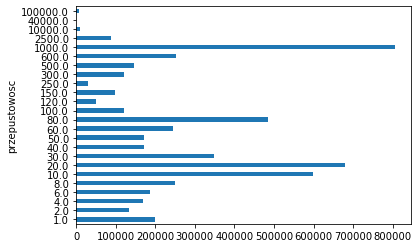

In [8]:
df['przepustowosc'].groupby(df['przepustowosc']).count().plot(kind='barh')

In [9]:
temp = df['copper_nonxdsl_count'].groupby(df['copper_nonxdsl_count']).count()
len(temp.index)

6309

In [10]:
temp[temp.index >= 1000].sum()

398080

In [11]:
temp[temp.index >= 1000]

copper_nonxdsl_count
1000    397
1001    365
1002    383
1003    360
1004    369
       ... 
6332      1
6333      2
6335      3
6336      2
6340      1
Name: copper_nonxdsl_count, Length: 5309, dtype: int64

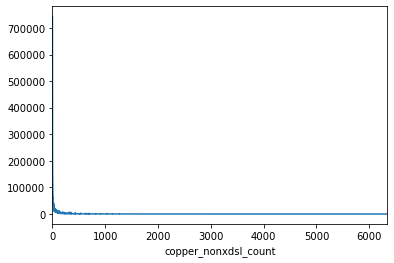

In [12]:
temp.plot()

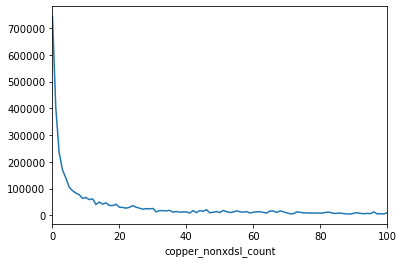

In [13]:
temp[temp.index <= 100].plot()  # wykres dla liczby rekordów do 100 węzłów

In [14]:
df['building_area'].sort_values(ascending=False)[:1000]

4789246    151230.746050
3278193     97594.134850
3518577     95780.454751
1217863     87784.993750
4634798     81330.268800
               ...      
3000080     11100.606950
1733732     11099.611295
1079710     11099.611295
3826826     11094.068000
4307215     11079.698850
Name: building_area, Length: 1000, dtype: float64

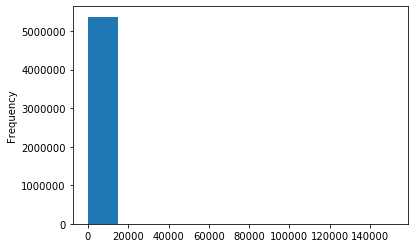

In [15]:
df['building_area'].plot(kind='hist', bins=10)

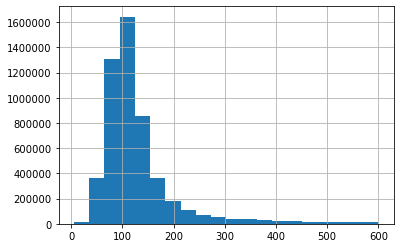

In [16]:
df[df['building_area'] < 600]['building_area'].hist(bins=20)

In [17]:
df[df['building_area'] >= 10000]['building_area'].count()

1175

In [18]:
df[df['przepustowosc'] > 2500]['przepustowosc'].count()

17294

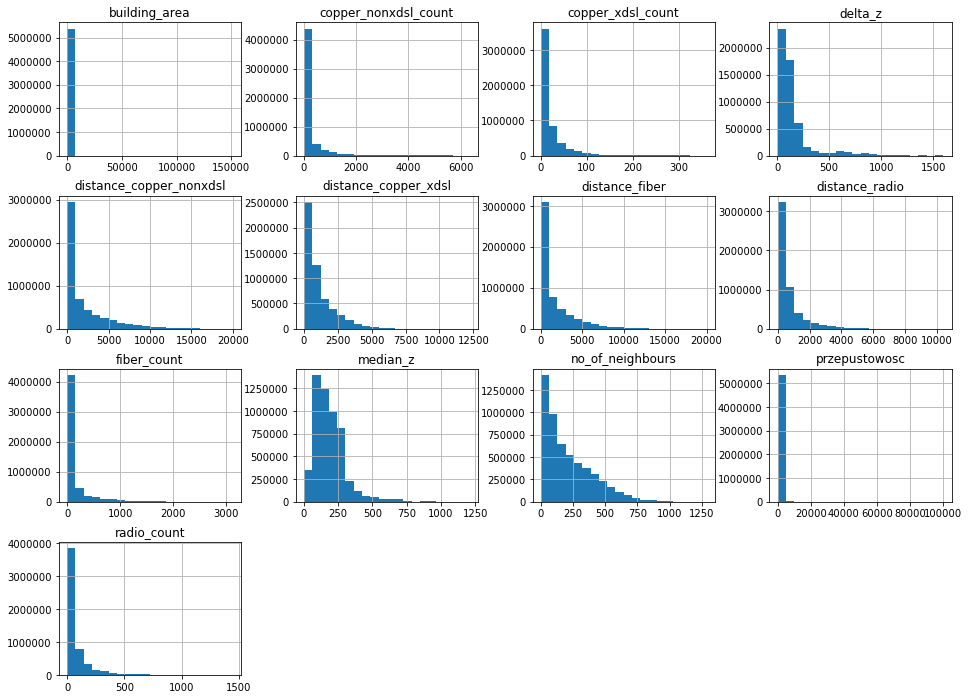

In [19]:
import matplotlib.pyplot as plt
_ = df.hist(figsize=(16,12), bins=20)
plt.show()

Przepustowości zostaną podzielone na klasy, które będą przewidywane przez model. Wyróżnimy 5 klas:
1 - 1-8 mbit/s  
2 - 10-20 mbit/s  
3 - 30-80 mbit/s  
4 - 100-600 mbit/s  
5 - >=1000 mbit/s  
(klasy nie zazęiają się bo dane sprawozdawane do urzędu mają z góry określone wartości, tak więc nie ma możliwości przekazania przepustowości jak 90 mbit/s).

Usuniemy rekordy dla powierzchni budynków powyżej 10000.

Z liczbą węzłów ciężej ocenić, czy część z nich byłaby do usunięcia jako tzw. _outliery_, ponieważ jest bardo duży przedział wartości zawierających po kilka kilkadziesiąt rekordów. Pozostanie skalowanie dla zbioru.

In [20]:
#df = df[df['przepustowosc'] <= 2500]

In [21]:
df = df[df['building_area'] <= 10000]

In [22]:
classes = {
    1: {'from': 0, 'to': 9, 'desc': '1-8 mbit/s'},
    2: {'from': 10, 'to': 20, 'desc': '10-20 mbit/s'},
    3: {'from': 30, 'to': 80, 'desc': '30-80 mbit/s'},
    4: {'from': 100, 'to': 600, 'desc': '100-600 mbit/s'},
    5: {'from': 601, 'to': 9999999, 'desc': '>=1000 mbit/s'},
}
labels = list(classes.keys())
desc_labels = [x['desc'] for x in classes.values()]

def classify(x):
    for k, v in classes.items():
        if v['from'] <= x <= v['to']:
            return k

df['class'] = df['przepustowosc'].apply(classify)
df.drop(columns=['przepustowosc'], inplace=True)

In [23]:
from numpy import log1p
from sklearn.preprocessing import MinMaxScaler

df['distance_copper_nonxdsl'] = df['distance_copper_nonxdsl'].apply(log1p)
df['distance_copper_xdsl'] = df['distance_copper_xdsl'].apply(log1p)
df['distance_fiber'] = df['distance_fiber'].apply(log1p)
df['distance_radio'] = df['distance_radio'].apply(log1p)
df['copper_nonxdsl_count'] = df['copper_nonxdsl_count'].apply(log1p)
df['copper_xdsl_count'] = df['copper_xdsl_count'].apply(log1p)
df['fiber_count'] = df['fiber_count'].apply(log1p)
df['radio_count'] = df['radio_count'].apply(log1p)
df['building_area'] = df['building_area'].apply(log1p)
df['no_of_neighbours'] = df['no_of_neighbours'].apply(log1p)

mms = MinMaxScaler()
df[['delta_z','median_z']] = mms.fit_transform(df[['delta_z','median_z']])

In [24]:
# change DataFrame column order
cols = [
    'class',
    'building_area',
    'no_of_neighbours',
    'delta_z',
    'median_z',
    'distance_copper_nonxdsl',
    'distance_copper_xdsl',
    'distance_fiber',
    'distance_radio',
    'copper_nonxdsl_count',
    'copper_xdsl_count',
    'fiber_count',
    'radio_count',
]
df = df[cols]

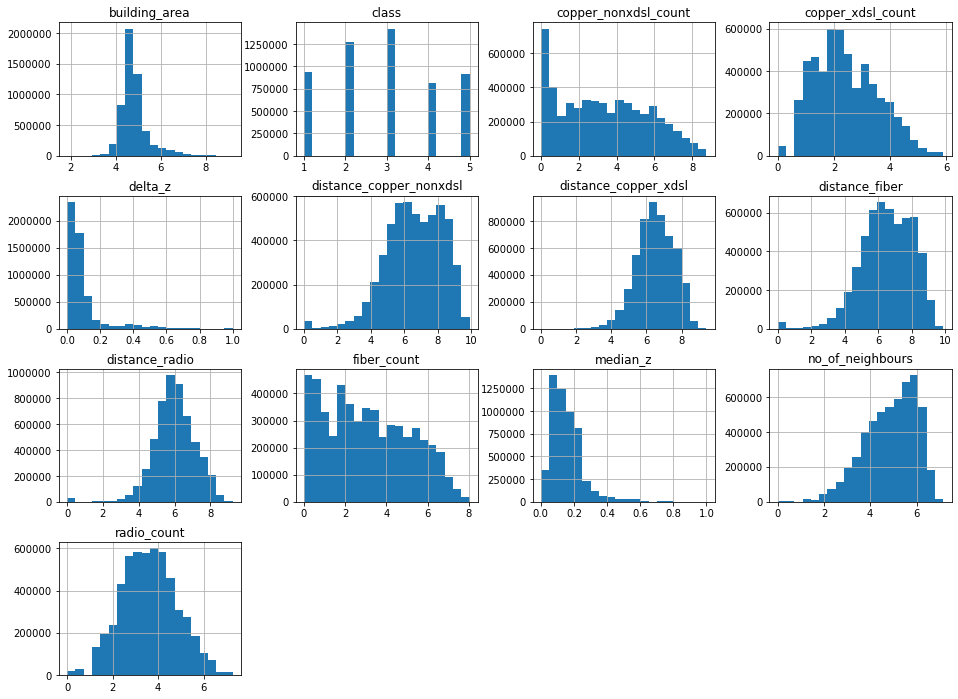

In [25]:
import matplotlib.pyplot as plt
_ = df.hist(figsize=(16,12), bins=20)
plt.show()

Spójrzemy teraz jak wyglądają nasze dane, które wykorzystamy do modelu.

In [26]:
df.head()

,class,building_area,no_of_neighbours,delta_z,median_z,distance_copper_nonxdsl,distance_copper_xdsl,distance_fiber,distance_radio,copper_nonxdsl_count,copper_xdsl_count,fiber_count,radio_count
0,3,4.895902,4.852030,0.081481,0.170570,7.819632,7.668706,7.668706,4.517650,6.131226,2.564949,4.882802,3.637586
1,1,4.982203,5.683580,0.016997,0.083743,6.425728,6.894133,6.633647,6.310954,5.023881,3.526361,4.219508,4.077537
2,3,4.485773,5.117994,0.087273,0.196575,8.030618,5.968017,5.968017,5.851973,1.098612,1.098612,1.098612,2.484907
3,3,4.751227,5.446737,0.146884,0.174091,6.238637,6.260709,6.279572,6.190110,3.931826,3.258097,2.302585,4.369448
4,3,6.495556,5.953243,0.289537,0.315122,4.843715,5.142131,4.631033,4.896944,5.356586,3.850148,5.683580,4.382027


In [27]:
df.shape

(5369004, 13)

In [28]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,class,building_area,no_of_neighbours,delta_z,median_z,distance_copper_nonxdsl,distance_copper_xdsl,distance_fiber,distance_radio,copper_nonxdsl_count,copper_xdsl_count,fiber_count,radio_count
count,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00,5369004.00
mean,2.90,4.82,4.89,0.09,0.15,6.61,6.50,6.53,5.99,3.29,2.44,3.10,3.61
std,1.33,0.59,1.11,0.11,0.10,1.67,1.05,1.53,1.14,2.35,1.12,2.05,1.21
min,1.00,1.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,4.49,4.13,0.04,0.09,5.48,5.81,5.54,5.32,1.10,1.61,1.39,2.77
50%,3.00,4.72,5.05,0.06,0.14,6.66,6.51,6.57,5.99,3.18,2.30,2.89,3.58
75%,4.00,4.99,5.79,0.10,0.20,7.98,7.28,7.75,6.72,5.16,3.22,4.75,4.41
max,5.00,9.21,7.16,1.00,1.00,9.90,9.41,9.90,9.25,8.75,5.89,8.05,7.28


Liczebność klas

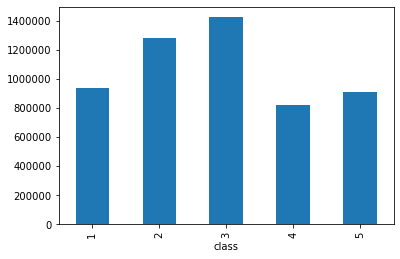

In [29]:
df['class'].groupby(df['class']).count().plot(kind='bar')

Macierz korelacji.

In [30]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,class,building_area,no_of_neighbours,delta_z,median_z,distance_copper_nonxdsl,distance_copper_xdsl,distance_fiber,distance_radio,copper_nonxdsl_count,copper_xdsl_count,fiber_count,radio_count
class,1,0.15,0.28,0.0048,0.054,-0.24,-0.31,-0.34,-0.21,0.2,0.22,0.25,0.22
building_area,0.15,1,0.079,-0.0093,-0.061,-0.29,-0.19,-0.24,-0.17,0.2,0.19,0.17,0.17
no_of_neighbours,0.28,0.079,1,-0.017,-0.064,-0.58,-0.56,-0.6,-0.46,0.58,0.56,0.56,0.55
delta_z,0.0048,-0.0093,-0.017,1,0.8,0.02,-0.002,0.01,-0.028,-0.022,0.047,0.022,0.093
median_z,0.054,-0.061,-0.064,0.8,1,0.093,0.04,0.035,-0.0021,-0.081,0.0036,0.014,0.054
distance_copper_nonxdsl,-0.24,-0.29,-0.58,0.02,0.093,1,0.43,0.6,0.5,-0.73,-0.59,-0.59,-0.62
distance_copper_xdsl,-0.31,-0.19,-0.56,-0.002,0.04,0.43,1,0.51,0.36,-0.34,-0.42,-0.31,-0.31
distance_fiber,-0.34,-0.24,-0.6,0.01,0.035,0.6,0.51,1,0.42,-0.53,-0.5,-0.64,-0.52
distance_radio,-0.21,-0.17,-0.46,-0.028,-0.0021,0.5,0.36,0.42,1,-0.36,-0.31,-0.33,-0.45
copper_nonxdsl_count,0.2,0.2,0.58,-0.022,-0.081,-0.73,-0.34,-0.53,-0.36,1,0.86,0.84,0.86


Jak widać najbardziej skorelowanymi zmiennymi są odległości od węzła telekomunikacyjnego (odwrotna korelacja) w technologii światłowodowej i xDSL. Zmienne na temat ukształtowania terenu: zmiana wysokości i mediana wysokości nie wykazują prawie żadnej korelacji.

Ostatnia rzecz to podzielenie danych na zbiór treningowy i testowy. Jako, że mamy dużo obserwacji zastosujemy podział 90% zbioru na trenowanie i 10% na testowanie.

In [31]:
from sklearn.model_selection import train_test_split

x = df[[x for x in df.columns if x != 'class']]
y = df['class']

train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.9, test_size=0.1)

## Model uczenia maszynowego

...

Do oceny modeli użyjemy wskaźników accuracy score oraz balanced accuracy score, a także [confusion matrix](https://pl.wikipedia.org/wiki/Tablica_pomy%C5%82ek).

In [32]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, plot_confusion_matrix, accuracy_score, classification_report

Sprawdzimy jak radzą sobie podstawowe algorytmy.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

models = {
    'dt': DecisionTreeClassifier(),
    'knn': KNeighborsClassifier(n_jobs=-1),
    'rf': RandomForestClassifier(n_jobs=-1),
    'xgb': HistGradientBoostingClassifier()  
}
predictions = {}

Trenujemy modele na naszych danych.

komenda _%%time_ pokaże jak długo kod z danej komórki się wykonywał

In [34]:
%%time
models['dt'].fit(train_x, train_y)
predictions['dt'] = models['dt'].predict(test_x)

Wall time: 5min 46s


In [35]:
%%time
models['knn'].fit(train_x, train_y)
predictions['knn'] = models['knn'].predict(test_x)

Wall time: 6min 39s


In [36]:
%%time
models['xgb'].fit(train_x, train_y)
predictions['xgb'] = models['xgb'].predict(test_x)

Wall time: 3min 14s


In [47]:
%%time
models['rf'].fit(train_x, train_y)
predictions['rf'] = models['rf'].predict(test_x)

Wall time: 12min


In [37]:
print('model: Decision Tree')
print('balanced_accuracy_score:', balanced_accuracy_score(test_y, predictions['dt']))
print('accuracy_score:', accuracy_score(test_y, predictions['dt']))
print('classification_report:')
print(classification_report(test_y, predictions['dt'], labels=labels))

model: Decision Tree
balanced_accuracy_score: 0.7558776924836274
accuracy_score: 0.7500395789912851
classification_report:
              precision    recall  f1-score   support

           1       0.74      0.74      0.74     93901
           2       0.69      0.69      0.69    127691
           3       0.75      0.75      0.75    142055
           4       0.78      0.78      0.78     82134
           5       0.83      0.82      0.82     91120

    accuracy                           0.75    536901
   macro avg       0.76      0.76      0.76    536901
weighted avg       0.75      0.75      0.75    536901



In [38]:
confusion_matrix(test_y, predictions['dt'], labels=labels)

array([[ 69570,  12599,   6851,   2322,   2559],
       [ 12807,  87642,  16714,   5914,   4614],
       [  6583,  16623, 106424,   6858,   5567],
       [  2335,   5774,   6850,  63994,   3181],
       [  2561,   4621,   5660,   3211,  75067]], dtype=int64)

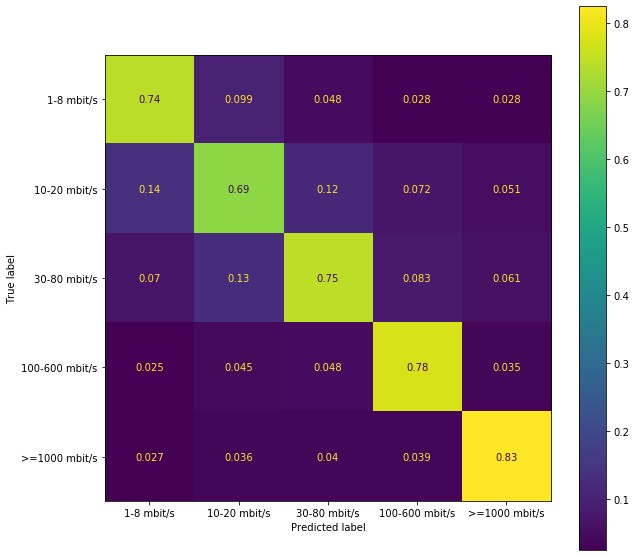

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
_ = plot_confusion_matrix(models['dt'], test_x, test_y, labels, display_labels=desc_labels, normalize='pred', ax=ax)
plt.show()

In [40]:
print('model: KNN')
print('balanced_accuracy_score:', balanced_accuracy_score(test_y, predictions['knn']))
print('accuracy_score:', accuracy_score(test_y, predictions['knn']))
print('classification_report:')
print(classification_report(test_y, predictions['knn'], labels=labels))

model: KNN
balanced_accuracy_score: 0.7761879731390179
accuracy_score: 0.7693187384638881
classification_report:
              precision    recall  f1-score   support

           1       0.74      0.81      0.77     93901
           2       0.72      0.70      0.71    127691
           3       0.78      0.76      0.77    142055
           4       0.78      0.79      0.79     82134
           5       0.84      0.82      0.83     91120

    accuracy                           0.77    536901
   macro avg       0.77      0.78      0.77    536901
weighted avg       0.77      0.77      0.77    536901



In [41]:
confusion_matrix(test_y, predictions['knn'], labels=labels)

array([[ 75649,   9550,   4198,   2234,   2270],
       [ 13912,  89621,  14502,   5560,   4096],
       [  7559,  15244, 107778,   6462,   5012],
       [  2340,   5212,   6621,  65225,   2736],
       [  2692,   4445,   5569,   3639,  74775]], dtype=int64)

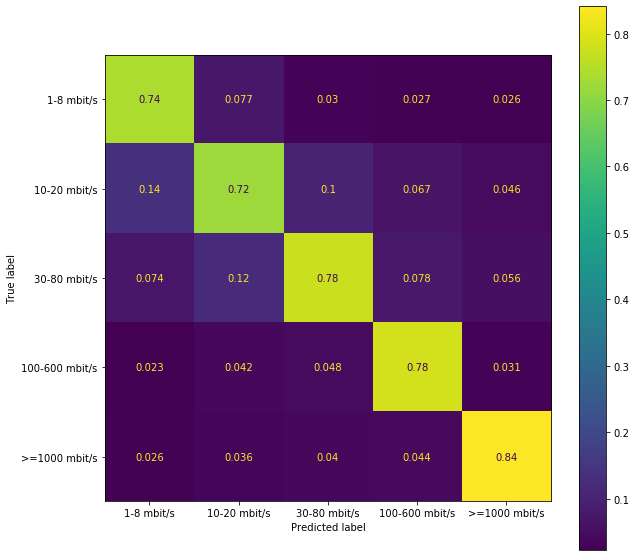

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
_ = plot_confusion_matrix(models['knn'], test_x, test_y, labels, display_labels=desc_labels, normalize='pred', ax=ax)
plt.show()

In [46]:
print('model: HistGradientBoosting')
print('balanced_accuracy_score:', balanced_accuracy_score(test_y, predictions['xgb']))
print('accuracy_score:', accuracy_score(test_y, predictions['xgb']))
print('classification_report:')
print(classification_report(test_y, predictions['xgb'], labels=labels))

model: HistGradientBoosting
balanced_accuracy_score: 0.5672331028087197
accuracy_score: 0.5754040316557428
classification_report:
              precision    recall  f1-score   support

           1       0.58      0.66      0.62     93901
           2       0.51      0.52      0.51    127691
           3       0.58      0.66      0.62    142055
           4       0.65      0.45      0.53     82134
           5       0.62      0.54      0.58     91120

    accuracy                           0.58    536901
   macro avg       0.59      0.57      0.57    536901
weighted avg       0.58      0.58      0.57    536901



In [44]:
confusion_matrix(test_y, predictions['xgb'], labels=labels)

array([[62139, 18971,  6332,  1796,  4663],
       [19209, 65912, 28280,  5934,  8356],
       [10766, 20637, 94449,  6958,  9245],
       [ 7049, 12338, 17404, 37288,  8055],
       [ 8801, 12235, 15362,  5575, 49147]], dtype=int64)

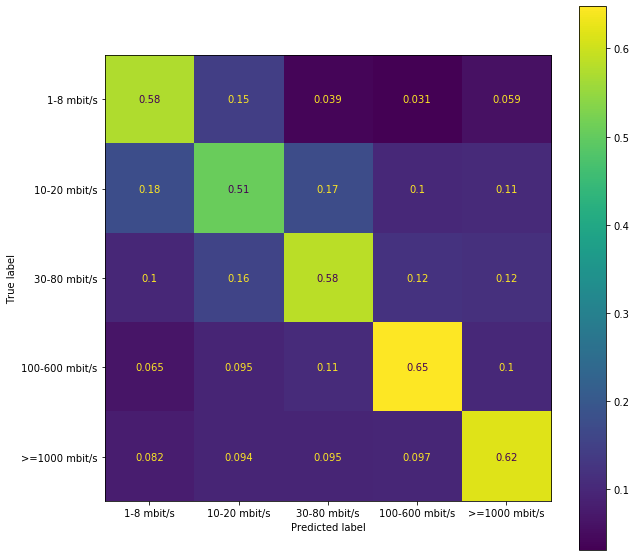

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
_ = plot_confusion_matrix(models['xgb'], test_x, test_y, labels, display_labels=desc_labels, normalize='pred', ax=ax)
plt.show()

In [48]:
print('model: Random Forest')
print('balanced_accuracy_score:', balanced_accuracy_score(test_y, predictions['rf']))
print('accuracy_score:', accuracy_score(test_y, predictions['rf']))
print('classification_report:')
print(classification_report(test_y, predictions['rf'], labels=labels))

model: Random Forest
balanced_accuracy_score: 0.82536873633716
accuracy_score: 0.8183557117606411
classification_report:
              precision    recall  f1-score   support

           1       0.80      0.83      0.81     93901
           2       0.78      0.75      0.77    127691
           3       0.82      0.81      0.81    142055
           4       0.83      0.85      0.84     82134
           5       0.87      0.88      0.88     91120

    accuracy                           0.82    536901
   macro avg       0.82      0.83      0.82    536901
weighted avg       0.82      0.82      0.82    536901



In [49]:
confusion_matrix(test_y, predictions['rf'], labels=labels)

array([[ 77917,   8379,   3956,   1825,   1824],
       [ 10841,  96230,  12357,   4792,   3471],
       [  5957,  11740, 114753,   5400,   4205],
       [  1556,   3605,   4743,  70158,   2072],
       [  1713,   2981,   3814,   2294,  80318]], dtype=int64)

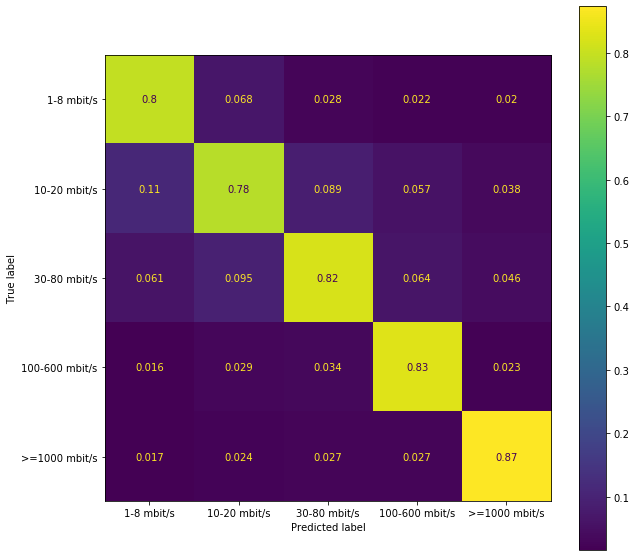

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
_ = plot_confusion_matrix(models['rf'], test_x, test_y, labels, display_labels=desc_labels, normalize='pred', ax=ax)
plt.show()

...

## Podsumowanie

W ramach tego projektu przygotowano zbiór danych w oparciu o otwarte źródła danych. W sumie pobrano i przetworzono kilkadziesiąt gigabajtów danych. Przetworzono je do wspólnego formatu, wyfiltrowano potrzebne informacje i połączono między sobą na podstawie atrybutów zarówno opisowych (adres) jak i przestrzennych (położenie). Niestety część źródeł, które chciałem wykorzystać była płatna jak np. dane z rejestru NOBC prowadzonego przez GUS, które wyceniono na 2500 zł brutto (na cele naukowe), a o część źródeł nie zdążyłem wystąpić jak np. zagregowane dane z rejestru PESEL.

Jak pokazały wyniki ... .

Ćwiczenie mogłoby zostać powtórzone z dodaniem nowych zbiorów danych, które mogły by rozszerzyć obecny o informacje takie jak liczba lokali w budynku/sąsiedztwie, czy dane demograficzne. Dodatkowo można by przeprowadzić głębszą analizę poprawności danych o infrastrukturze i zastosować dodatkowe kroki przetwarzania ze względu na to że występują spore różnice między tym jak poszczególni przedsiębiorcy się sprawozdają, alternatywnie przyjąć inne założenia co do wykorzystania danych o infrastrukturze, ponieważ tutaj dane podzieliliśmy tylko na 4 kategorie technologii podczas gdy technologii jest więcej.

---
---
Wytrenowane modele można zapisać na dysku:

In [51]:
from joblib import dump, load

for k, v in models.items():
    dump(v, k+'.joblib')

In [52]:
df.to_csv('df.zip', index=False, sep=';')